In [65]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from matplotlib.patches import Patch
import datetime as dt

In [5]:
# read in all the retrieved posts
messages_df = pd.read_csv("../data/clean_data/all_posts_cleaned.csv")

# create proper date columns
messages_df["date"] = pd.to_datetime(messages_df["date"], utc=True, format="mixed", errors="raise")
messages_df["year"] = messages_df["date"].dt.isocalendar().year
messages_df["week"] = messages_df["date"].dt.isocalendar().week
messages_df["simple_date"] = messages_df["date"].dt.date
messages_df['year_week'] = messages_df['year'].astype(str) + '-W' + messages_df['week'].astype(str).str.zfill(2)

In [8]:
# create proper date columns
messages_df["date"] = pd.to_datetime(messages_df["date"], utc=True, format="mixed", errors="raise")
messages_df["year"] = messages_df["date"].dt.isocalendar().year
messages_df["week"] = messages_df["date"].dt.isocalendar().week
messages_df["simple_date"] = messages_df["date"].dt.date
messages_df['year_week'] = messages_df['year'].astype(str) + '-W' + messages_df['week'].astype(str).str.zfill(2)

# limit the df to messages from 2024 and 2025
messages_df = messages_df[(messages_df["year"] == 2024) | (messages_df["year"] == 2025)]

In [9]:
print(f"Number of different users posting over the whole timeframe: {len(set(messages_df["clean_handle"]))}")
print(f"Number of overall posts: {len(messages_df)}")

Number of different users posting over the whole timeframe: 164
Number of overall posts: 17173


In [10]:
# count the number of posts per day
group_df = messages_df.groupby("simple_date").size().reset_index(name="count")
group_df.head()

,simple_date,count
0,2024-06-01,21
1,2024-06-02,19
2,2024-06-03,27
3,2024-06-04,25
4,2024-06-05,23


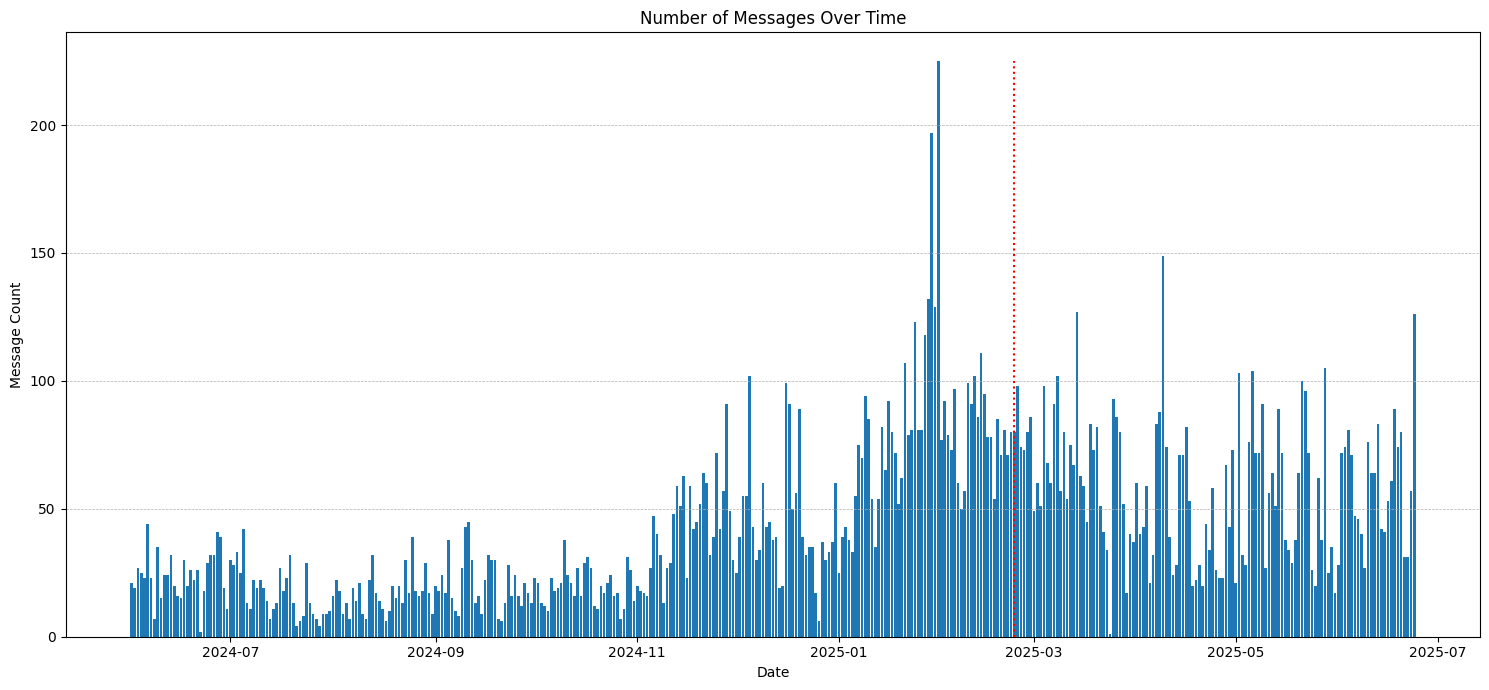

In [16]:
# visualize the number of messages over time
plt.figure(figsize=(15, 7))
plt.bar(group_df["simple_date"], group_df["count"])
plt.title("Number of Messages Over Time")
plt.xlabel("Date")
plt.ylabel("Message Count")
plt.vlines(dt.datetime(2025, 2, 23), ymin=0, ymax=max(group_df["count"]), colors="red", linestyles="dotted")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()
plt.show()

In [26]:
# read in the MP datasets
bt_21_df = pd.read_csv("../data/clean_data/bundestag_21_clean.csv")
bt_25_df = pd.read_csv("../data/clean_data/bundestag_25_clean.csv")

# reduce to only those mps having a bsky account
bt_21_bsky_df = bt_21_df[~bt_21_df["clean_handle"].isna()]
bt_25_bsky_df = bt_25_df[~bt_25_df["clean_handle"].isna()]

# count the number of mps per party
party_shares_21 = bt_21_df.groupby("faction").size()
party_shares_25 = bt_25_df.groupby("faction").size()

# count the number of mps per party which have a bsky account
party_shares_bsky_21 = bt_21_bsky_df.groupby("faction").size()
party_shares_bsky_25 = bt_25_bsky_df.groupby("faction").size()

In [53]:
# --- Define party color map ---
party_colors = {
    'CDU/CSU': '#000000',
    'SPD': '#E3000F',
    'Grünen': '#46962B',
    'FDP': '#FFCC00',
    'AfD': '#009EE0',
    'Die LINKE': '#BE3075',
    'BSW': '#f0715f',
    'Fraktionslos': '#999999',
}

# --- Helper function to lighten a color ---
def lighten(color, factor=0.5):
    rgb = to_rgb(color)
    return [(1 - factor) * c + factor for c in rgb]

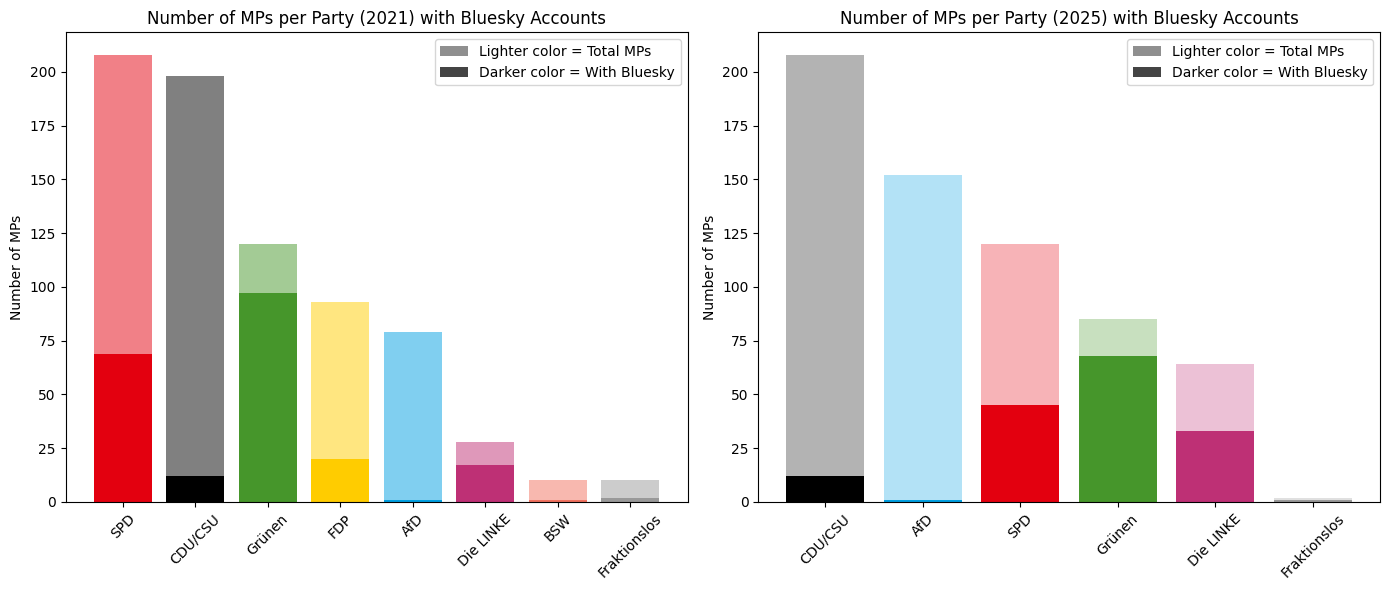

In [88]:
# create legend elements
legend_elements = [
    Patch(facecolor=lighten("#444444", 0.4), label="Lighter color = Total MPs"),
    Patch(facecolor="#444444", label="Darker color = With Bluesky")
]

# ensure that all parties appear in the plots (for both total and bsky count)
all_factions_21 = party_shares_21.index.union(party_shares_bsky_21.index)
total_mps_21 = party_shares_21.reindex(all_factions_21, fill_value=0)
bsky_mps_21 = party_shares_bsky_21.reindex(all_factions_21, fill_value=0)
sorted_indices_21 = total_mps_21.sort_values(ascending=False).index

all_factions_25 = party_shares_25.index.union(party_shares_bsky_25.index)
total_mps_25 = party_shares_25.reindex(all_factions_25, fill_value=0)
bsky_mps_25 = party_shares_bsky_25.reindex(all_factions_25, fill_value=0)
sorted_indices_25 = total_mps_25.sort_values(ascending=False).index

# plot in two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Base bar for total MPs
for party in sorted_indices_21:
    color = party_colors[party]
    axes[0].bar(party, total_mps_21[party], color = lighten(color))
    axes[0].bar(party, bsky_mps_21[party], color = color)
axes[0].set_ylabel("Number of MPs")
axes[0].set_title("Number of MPs per Party (2021) with Bluesky Accounts")

for party in sorted_indices_25:
    color = party_colors[party]
    axes[1].bar(party, total_mps_25[party], color = lighten(color, factor=.7))
    axes[1].bar(party, bsky_mps_25[party], color = color)
axes[1].set_ylabel("Number of MPs")
axes[1].set_title("Number of MPs per Party (2025) with Bluesky Accounts")

axes[0].legend(handles=legend_elements, loc='upper right', ncol=1)
axes[1].legend(handles=legend_elements, loc='upper right', ncol=1)

axes[0].tick_params(axis="x", rotation=45)
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [81]:
# cut the posts df in two according to legislature
messages_21_df = messages_df[messages_df["simple_date"] <= dt.date(2025, 3, 24)]
messages_25_df = messages_df[messages_df["simple_date"] >= dt.date(2025, 3, 25)]

# count the number of posting mp per party
posting_mps_21 = messages_21_df.drop_duplicates(subset=["clean_handle"]).groupby("faction").size()
posting_mps_25 = messages_25_df.drop_duplicates(subset=["clean_handle"]).groupby("faction").size()

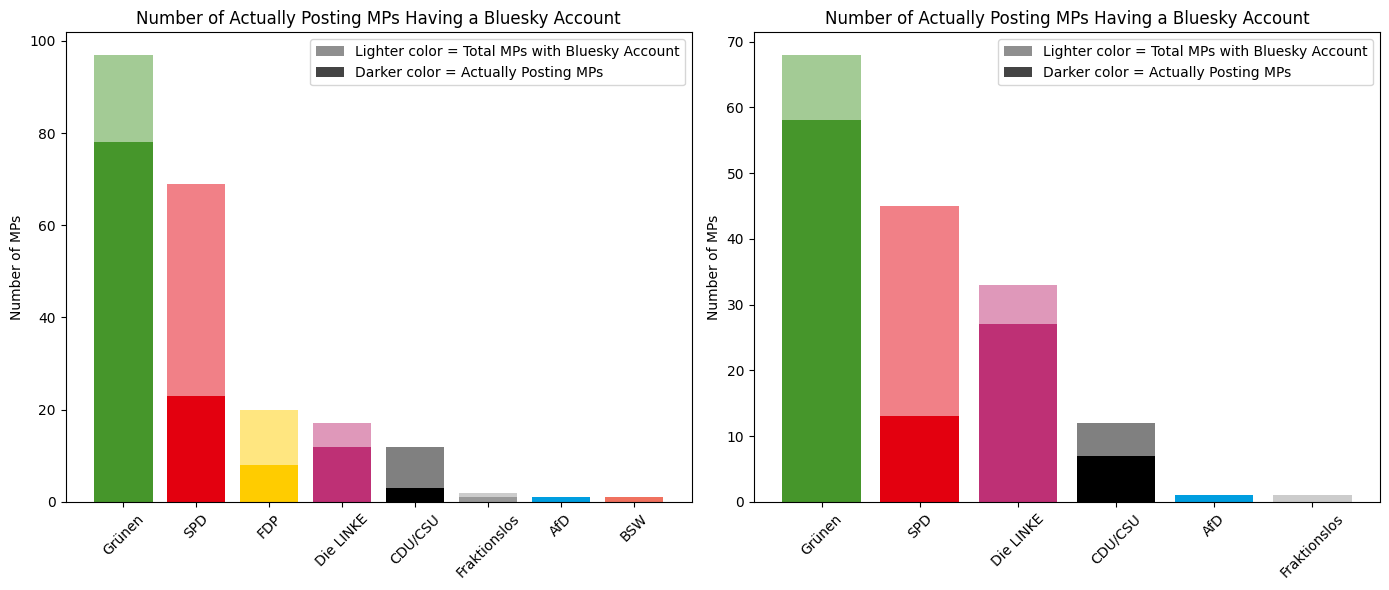

In [85]:
# create legend elements
legend_elements = [
    Patch(facecolor=lighten("#444444", 0.4), label="Lighter color = Total MPs with Bluesky Account"),
    Patch(facecolor="#444444", label="Darker color = Actually Posting MPs")
]

# ensure that all parties appear in the plots (for both total and bsky count)
all_factions_bsky_21 = party_shares_bsky_21.index.union(posting_mps_21.index)
party_shares_bsky_21 = party_shares_bsky_21.reindex(all_factions_bsky_21, fill_value=0)
posting_mps_21 = posting_mps_21.reindex(all_factions_bsky_21, fill_value=0)
sorted_indices_21 = party_shares_bsky_21.sort_values(ascending=False).index

all_factions_bsky_25 = party_shares_bsky_25.index.union(posting_mps_25.index)
party_shares_bsky_25 = party_shares_bsky_25.reindex(all_factions_bsky_25, fill_value=0)
posting_mps_25 = posting_mps_25.reindex(all_factions_bsky_25, fill_value=0)
sorted_indices_25 = party_shares_bsky_25.sort_values(ascending=False).index

# plot in two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Base bar for total MPs
for party in sorted_indices_21:
    color = party_colors[party]
    axes[0].bar(party, party_shares_bsky_21[party], color = lighten(color))
    axes[0].bar(party, posting_mps_21[party], color = color)
axes[0].set_ylabel("Number of MPs")
axes[0].set_title("Number of Actually Posting MPs Having a Bluesky Account")

for party in sorted_indices_25:
    color = party_colors[party]
    axes[1].bar(party, party_shares_bsky_25[party], color = lighten(color))
    axes[1].bar(party, posting_mps_25[party], color = color)
axes[1].set_ylabel("Number of MPs")
axes[1].set_title("Number of Actually Posting MPs Having a Bluesky Account")

axes[0].legend(handles=legend_elements, loc='upper right', ncol=1)
axes[1].legend(handles=legend_elements, loc='upper right', ncol=1)

axes[0].tick_params(axis="x", rotation=45)
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()